In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange as rand
from Quality import compute_overlap_array, get_unique_overlap
from skimage.measure import label

# Data Simulation Functions
The following two functions are responsible for randomly populating volumes of a specified size with clusters.

There will be a bounded random number of clusters, each of which will have a bounded random radius in every dimension.

In [2]:
def generatePointSet(z, y, x,
                     minZRad,
                     maxZRad,
                     minYRad,
                     maxYRad,
                     minXRad,
                     maxXRad):
    center = (rand(0, z), rand(0, y), rand(0, x))
    toPopulate = []
    zRad = rand(minZRad, maxZRad)
    yRad = rand(minYRad, maxYRad)
    xRad = rand(minXRad, maxXRad)
    
    for cz in range(-zRad, zRad):
        for cy in range(-yRad, yRad):
            for cx in range(-xRad, xRad):
                curPoint = (center[0]+cz, center[1]+cy, center[2]+cx)
                #only populate valid points
                valid = True
                dimLimits = [z, y, x]
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= dimLimits[dim]:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)

In [3]:
def generateTestVolume(z, y, x,
                       minCluster,
                       maxCluster,
                       minZRad,
                       maxZRad,
                       minYRad,
                       maxYRad,
                       minXRad,
                       maxXRad):
    #create a test volume
    volume = np.zeros((z, y, x))
    myPointSet = set()
    for _ in range(rand(minCluster, maxCluster)):
        potentialPointSet = generatePointSet(z, y, x,
                                             minZRad,
                                             maxZRad,
                                             minYRad,
                                             maxYRad,
                                             minXRad,
                                             maxXRad)
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
            potentialPointSet = generatePointSet(z, y, x,
                                                 minZRad,
                                                 maxZRad,
                                                 minYRad,
                                                 maxYRad,
                                                 minXRad,
                                                 maxXRad)

        for elem in potentialPointSet:
            myPointSet.add(elem)
            
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 1
        
    return volume, list(myPointSet)

In [4]:
testVolume, testPoints = generateTestVolume(5, 25, 25,
                                            5,
                                            6,
                                            1,
                                            2,
                                            1,
                                            2,
                                            1,
                                            2)

# Visualization
Below is a snippet of code for visualizing the rendered test volumes

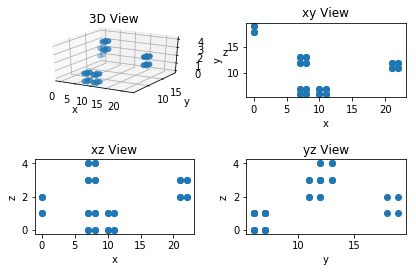

In [5]:
def visualize_volume(volume):
    points = np.nonzero(volume)
    zs = points[0]
    ys = points[1]
    xs = points[2]
    
    fig = plt.figure() 
    
    ax1=fig.add_subplot(2,2,1, projection='3d')
    ax2=fig.add_subplot(2,2,2)
    ax3=fig.add_subplot(2,2,3)
    ax4=fig.add_subplot(2,2,4) 
    
    ax1.set_title('3D View')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.scatter(xs, ys, zs)
    
    ax2.set_title('xy View')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.scatter(xs, ys)
    
    ax3.set_title('xz View')
    ax3.set_xlabel('x')
    ax3.set_ylabel('z')
    ax3.scatter(xs, zs)
    
    ax4.set_title('yz View')
    ax4.set_xlabel('y')
    ax4.set_ylabel('z')
    ax4.scatter(ys, zs)
    
    
    plt.tight_layout(pad=1.5)
    plt.show()
visualize_volume(testVolume)

# Test Methods
The first step is to check that, if the labels and predictions are perfect, that both histograms only have mass in their 1 bins. To check this, we pas the test volume as its own labels

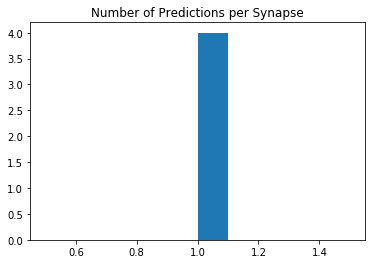

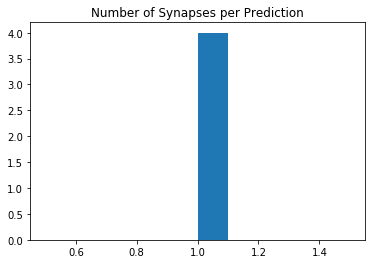

In [6]:
overlapDict = compute_overlap_array(testVolume, testVolume)
plt.hist(overlapDict['predictionPerGt'])
plt.title("Number of Predictions per Synapse")
plt.show()


plt.hist(overlapDict['gtPerPrediction'])
plt.title("Number of Synapses per Prediction")
plt.show()

As expected, all of the synapses overlap with 1 prediction, and all of the predictions overlap with 1 synapse
Now, a prediction is removed. The plot should respond by having a mass of 1 in the 0 bin in the synapse per prediction plot

remVolume


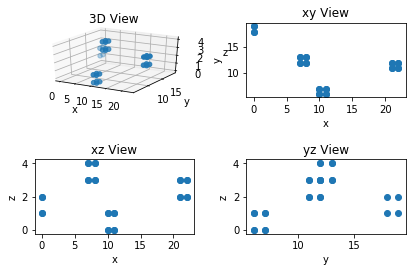


testVolume


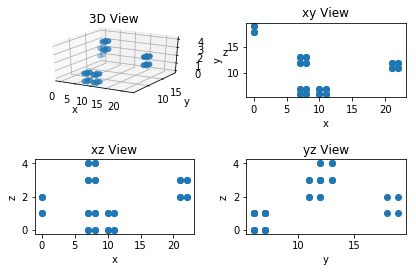

In [7]:
toRemove = np.where(label(testVolume) == 1)
zs = toRemove[0]
ys = toRemove[1]
xs = toRemove[2]

remVolume = np.copy(testVolume)
for i in range(len(zs)):
    remVolume[zs[i], ys[i], xs[i]]=0
print('remVolume')
visualize_volume(remVolume)
print('\ntestVolume')
visualize_volume(testVolume)

From the visualizations, we can see that one of the clusters has been removed from the remVolume

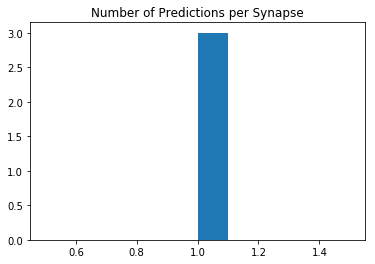

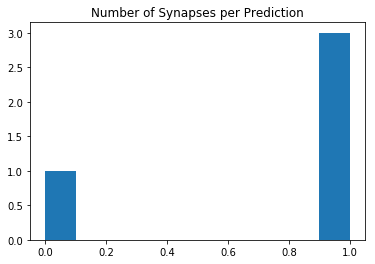

In [8]:
overlapDict = compute_overlap_array(testVolume, remVolume)
plt.hist(overlapDict['predictionPerGt'])
plt.title("Number of Predictions per Synapse")
plt.show()


plt.hist(overlapDict['gtPerPrediction'])
plt.title("Number of Synapses per Prediction")
plt.show()

The histogram responds correctly to this test.

The final step is to make sure that the histogram responds to multiple overlap of synapses. This should give the Synapses per prediction histogram a mass of 1 in the 2 bin

In [9]:
toChange = np.where(label(testVolume) == 1)
changeVolume = np.copy(testVolume)
z = toChange[0][0]
y = toChange[1][0]
x = toChange[2][0]

changeVolume[z, y, x] = 2

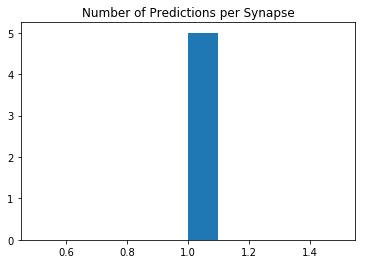

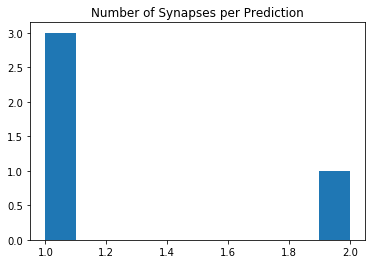

In [10]:
overlapDict = compute_overlap_array(testVolume, changeVolume)
plt.hist(overlapDict['predictionPerGt'])
plt.title("Number of Predictions per Synapse")
plt.show()


plt.hist(overlapDict['gtPerPrediction'])
plt.title("Number of Synapses per Prediction")
plt.show()

The plot responds as expected.